Loading news data... (This might take a moment)
Loaded 1407328 headlines.
   Unnamed: 0                                    headline  \
0           0     Stocks That Hit 52-Week Highs On Friday   
1           1  Stocks That Hit 52-Week Highs On Wednesday   
2           2               71 Biggest Movers From Friday   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  

Starting Sentiment Analysis... Go grab a coffee ☕
Sentiment Analysis Complete!
Saved processed data to ../data/news_with_sentiment.csv


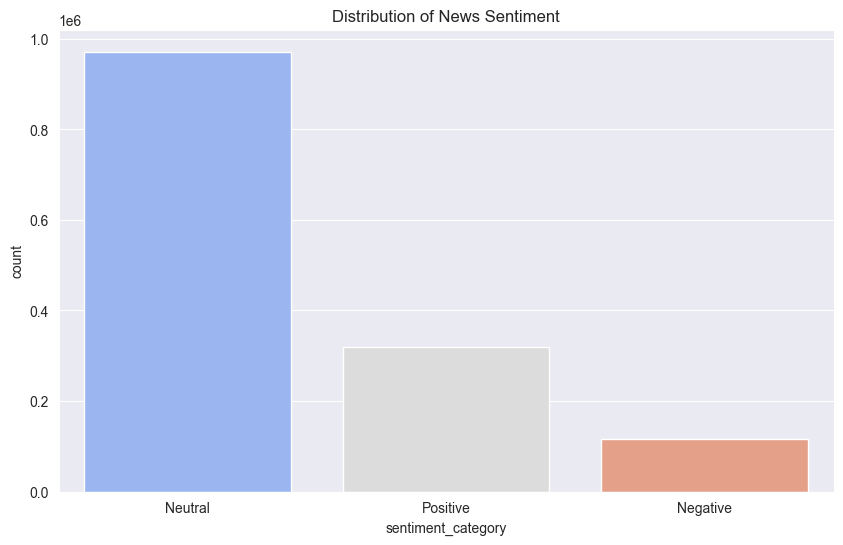

In [4]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the Raw News Data
# Replace with your actual filename
news_file = '../data/news/raw_analyst_ratings.csv'
print("Loading news data... (This might take a moment)")
news_df = pd.read_csv(news_file)

# 2. Normalize Dates (Crucial for Task 3 merging)
# The raw data has exact times (e.g., "2020-06-15 14:30:00")
# We need just the day (e.g., "2020-06-15") to match with stock data
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce', utc=True)
news_df['date'] = news_df['date'].dt.date # Keep only the YYYY-MM-DD

print(f"Loaded {len(news_df)} headlines.")
print(news_df.head(3))

# 3. Define Sentiment Function
# Returns a score from -1 (Very Negative) to +1 (Very Positive)
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

# 4. Apply Sentiment Analysis
# WARNING: Processing 1.4 million rows takes time (5-10 mins on some Macs).
# We print progress to keep you updated.
print("\nStarting Sentiment Analysis... Go grab a coffee ☕")

# We use a lambda function to apply TextBlob to every headline
news_df['sentiment'] = news_df['headline'].apply(get_sentiment)

print("Sentiment Analysis Complete!")

# 5. Categorize (Optional, but good for visualization)
def categorize_sentiment(score):
    if score > 0.05: return 'Positive'
    elif score < -0.05: return 'Negative'
    else: return 'Neutral'

news_df['sentiment_category'] = news_df['sentiment'].apply(categorize_sentiment)

# 6. Save the Processed Data
# We save this now so we NEVER have to wait for this calculation again.
output_file = '../data/news_with_sentiment.csv'
news_df.to_csv(output_file, index=False)
print(f"Saved processed data to {output_file}")

# 7. Visualize the Results
plt.figure(figsize=(10, 6))
sns.countplot(
    x='sentiment_category',
    data=news_df,
    hue='sentiment_category',
    legend=False,
    palette='coolwarm'
)
plt.title('Distribution of News Sentiment')
plt.show()

Loading and aggregating sentiment data...
Aggregated into 2502 days of sentiment data.


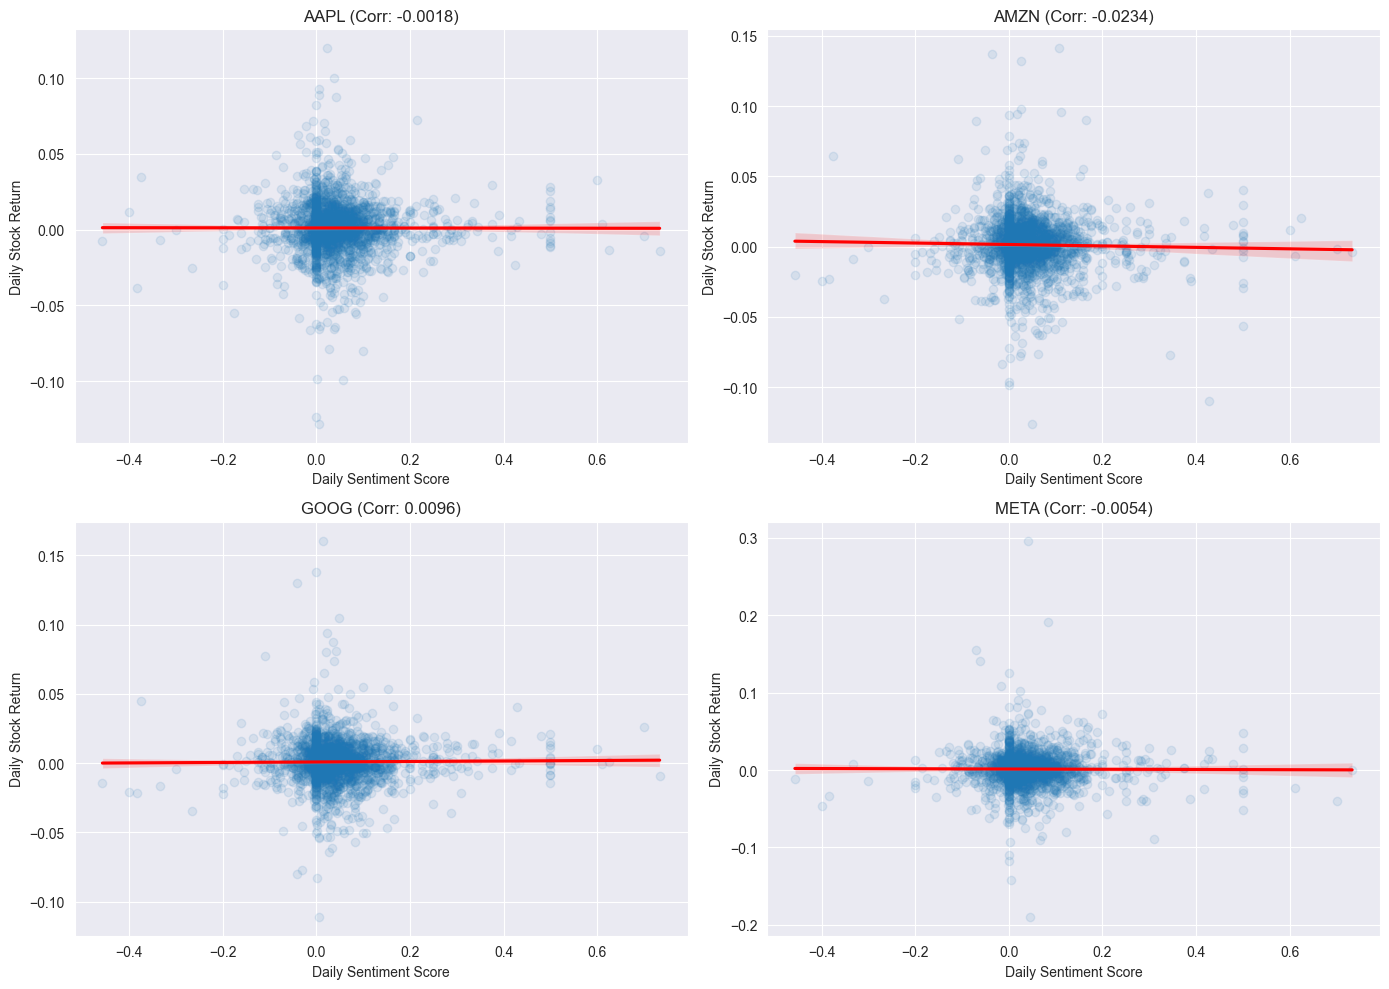


--- Final Correlation Analysis ---
  Stock  Correlation   P-Value
2  GOOG     0.009609  0.650772
5  NVDA     0.005822  0.783854
0  AAPL    -0.001778  0.933249
3  META    -0.005362  0.811475
4  MSFT    -0.009937  0.639663
1  AMZN    -0.023411  0.269989


In [5]:

from scipy.stats import pearsonr

# 1. Load the Sentiment Data (if not already loaded)
# We reload it to ensure date parsing is correct
sentiment_file = '../data/news_with_sentiment.csv'
print("Loading and aggregating sentiment data...")
news_df = pd.read_csv(sentiment_file)

# Ensure date is datetime for merging
news_df['date'] = pd.to_datetime(news_df['date']).dt.date

# 2. Aggregate Daily Sentiment
# We group by date and take the average sentiment for that day
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']) # Convert back to datetime64 for merging
daily_sentiment.set_index('date', inplace=True)

print(f"Aggregated into {len(daily_sentiment)} days of sentiment data.")

# 3. Stock Analysis Loop
stock_files = ['AAPL.csv', 'AMZN.csv', 'GOOG.csv', 'META.csv', 'MSFT.csv', 'NVDA.csv']
correlation_results = []

plt.figure(figsize=(14, 10))

for i, file_name in enumerate(stock_files):
    ticker = file_name.replace('.csv', '')
    stock_path = f"../data/{file_name}"

    try:
        # Load Stock Data
        stock_df = pd.read_csv(stock_path)
        stock_df['Date'] = pd.to_datetime(stock_df['Date'])
        stock_df.set_index('Date', inplace=True)

        # Calculate Daily Returns (if not already there)
        stock_df['Daily_Return'] = stock_df['Close'].pct_change()

        # 4. MERGE: Join Stock Returns with News Sentiment
        # We use 'inner' join to keep only days where we have BOTH news and stock data
        merged_df = stock_df.join(daily_sentiment, how='inner')

        # Drop NaN values created by the return calculation
        merged_df.dropna(subset=['Daily_Return', 'sentiment'], inplace=True)

        # 5. Calculate Correlation
        if not merged_df.empty:
            corr_coeff, p_value = pearsonr(merged_df['Daily_Return'], merged_df['sentiment'])
            correlation_results.append({'Stock': ticker, 'Correlation': corr_coeff, 'P-Value': p_value})

            # Scatter Plot (only for the first few to avoid clutter)
            if i < 4:
                plt.subplot(2, 2, i+1)
                sns.regplot(x='sentiment', y='Daily_Return', data=merged_df, scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
                plt.title(f'{ticker} (Corr: {corr_coeff:.4f})')
                plt.xlabel('Daily Sentiment Score')
                plt.ylabel('Daily Stock Return')

    except Exception as e:
        print(f"Could not process {ticker}: {e}")

plt.tight_layout()
plt.show()

# 6. Print the Final Results Table
results_df = pd.DataFrame(correlation_results).sort_values(by='Correlation', ascending=False)
print("\n--- Final Correlation Analysis ---")
print(results_df)